Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 253809.7812 - mae: 418.6929 - val_loss: 280591.4062 - val_mae: 447.6712
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 292731.6875 - mae: 458.1316 - val_loss: 279087.7188 - val_mae: 445.8801
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 246806.5781 - mae: 415.5529 - val_loss: 276013.2188 - val_mae: 442.2212
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 272982.6562 - mae: 443.4198 - val_loss: 269960.4688 - val_mae: 435.1803
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 255456.1562 - mae: 414.1993 - val_loss: 259105.1406 - val_mae: 422.3670
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 238148.4062 - mae: 401.4579 - val_loss: 241078.3750 - val_mae: 400.6514
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 226549.4219 - mae: 386.3106 - val_loss: 214435.8281 - val_mae: 369.7887
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 196889.5938 - mae: 353.2632 

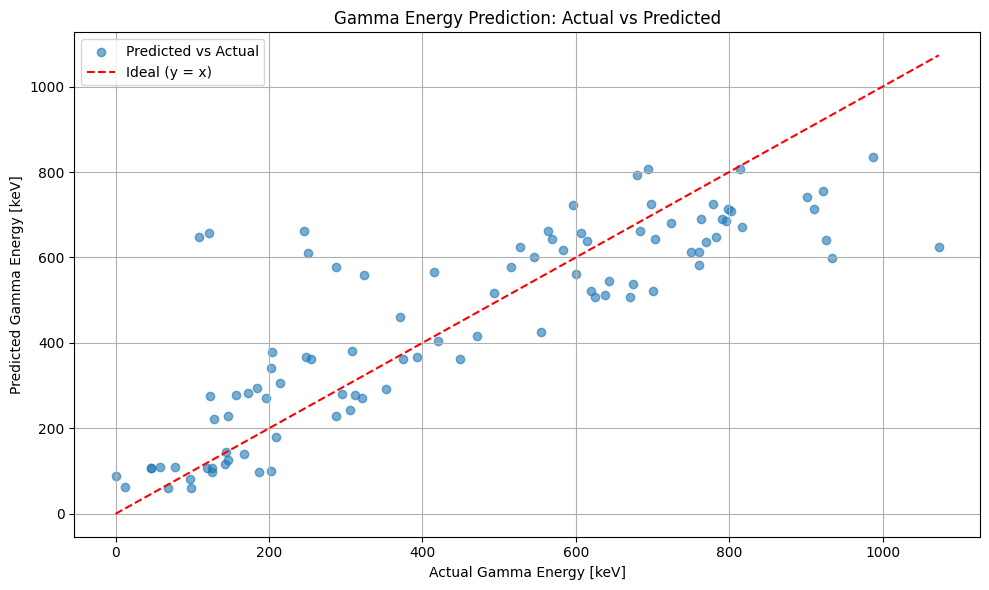

<Figure size 640x480 with 0 Axes>

In [4]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load CSV data
df = pd.read_csv("/kaggle/input/gammaraydata/U235_NDSData.csv", sep=',')  # Load nuclear data
df.columns = df.columns.str.strip()  # Remove extra spaces in column names

# Drop rows missing essential columns (to ensure clean input)
df = df.dropna(subset=['start level jp', 'energy [keV]', 'start level energy [keV]'])

# Function to parse spin (J) and parity (π) from 'start level jp' column
def parse_jp(jp):
    if pd.isna(jp):  # If value is missing, return default zeros
        return pd.Series([0.0, 0])
    spin, parity = jp[:-1], jp[-1]  # Separate spin and parity 
    try:
        spin_val = float(eval(spin))  # Convert fractional spin 
    except:
        spin_val = 0.0
    parity_val = 1 if parity == '+' else -1  # Map '+' → 1 and '-' → -1
    return pd.Series([spin_val, parity_val])

# Apply parsing function and create new columns 'spin' and 'parity'
df[['spin', 'parity']] = df['start level jp'].apply(parse_jp)

# Select features (start level energy, spin, parity) and labels (gamma energy)
features = df[['start level energy [keV]', 'spin', 'parity']]
labels = df['energy [keV]']

# Normalize features for better neural network performance
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2)

# Create TensorFlow datasets for efficient batching and shuffling
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Regression output (predicts gamma energy)
])

# Compile the model with optimizer, loss, and evaluation metric
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(train_ds, epochs=1000, validation_data=test_ds, callbacks=[early_stop])

# Evaluate model on test dataset
loss, mae = model.evaluate(test_ds)
print(f"Test Loss: {loss}, MAE: {mae}")

# Predict gamma energies for the test set
y_pred = model.predict(X_test).flatten()

# Plot actual vs predicted gamma energies
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal (y = x)')
plt.xlabel("Actual Gamma Energy [keV]")
plt.ylabel("Predicted Gamma Energy [keV]")
plt.title("Gamma Energy Prediction: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the plot as an image
plt.savefig('U-235_ModelEvaluation.png')

# Save the trained model
model.save("gamma_model.h5")